# Utilities
---------------------------------

This example shows various useful utilities that can be used to improve your pipelines.

The data used is a variation on the Australian weather dataset from [https://www.kaggle.com/jsphyg/weather-dataset-rattle-package](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package). The goal of this dataset is to predict whether or not it will rain tomorrow training a binay classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from sklearn.metrics import fbeta_score
from atom import ATOMClassifier, ATOMLoader

In [2]:
# Load data
X = pd.read_csv('./datasets/weatherAUS.csv')

# Let's have a look at the data
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Use the utility attributes

In [3]:
atom = ATOMClassifier(X, warnings=False, random_state=1)
atom.clean()

# We can quickly check what columns have missing values
print("Columns with missing values:\n", atom.nans)

# Or what columns are categorical
print("\nCategorical columns:", atom.categorical)

# Or if the dataset is scaled
print("\nIs the dataset scaled?", atom.scaled)

Columns with missing values:
 MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
dtype: int64

Categorical columns: ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']

Is the dataset scaled? False


## Use the stats method to check changes in the dataset

In [4]:
# Note the number of missing values and categorical columns
atom.stats()

Dataset stats ================== >>
Shape: (142193, 22)
Missing values: 316559
Categorical columns: 5
Scaled: False
-----------------------------------
Train set size: 113755
Test set size: 28438
-----------------------------------
Dataset balance: No:Yes <==> 3.5:1.0
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |    110316 |   88263 |  22053 |
|  1 |     31877 |   25492 |   6385 |


In [5]:
# Now, let's impute and encode the dataset...
atom.impute()
atom.encode()

# ... and the values are gone
atom.stats()

Dataset stats ================== >>
Shape: (56420, 22)
Scaled: False
-----------------------------------
Train set size: 45021
Test set size: 11399
-----------------------------------
Dataset balance: No:Yes <==> 3.5:1.0
-----------------------------------
Distribution of classes:
|    |   dataset |   train |   test |
|---:|----------:|--------:|-------:|
|  0 |     43993 |   35107 |   8886 |
|  1 |     12427 |    9914 |   2513 |


## Change the data mid-pipeline

In [6]:
# We can change atom's data mid-pipeline, adding a column for example
# Note that we can only replace a dataframe with a new dataframe!
atom.X = atom.X.assign(AvgTemp=(atom.X['MaxTemp'] + atom.X['MinTemp'])/2)

# This will automatically update all other data attributes
assert 'AvgTemp' in atom.dataset

## Use a custom metric

In [7]:
atom.verbose = 1

# Define a custom metric
def f2_score(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)

# Remember to use the greater_is_better, needs_proba and needs_threshold parameters if necessary!
atom.run(models='lr', metric=f2_score)


Training ===================================== >>
Models: LR
Metric: f2_score


Results for Logistic Regression:         
Fit ---------------------------------------------
Train evaluation --> f2_score: 0.5677
Test evaluation --> f2_score: 0.5691
Time elapsed: 0.000s
-------------------------------------------------
Total time: 0.000s


Final results ========================= >>
Duration: 0.000s
------------------------------------------
Logistic Regression --> f2_score: 0.569


## Customize the estimator's parameters

In [8]:
# You can use the est_params parameter to customize the estimator
# Let's run AdaBoost using LR instead of a decision tree as base estimator
atom.run('AdaB', est_params={'base_estimator': atom.lr.estimator})


Training ===================================== >>
Models: AdaB
Metric: f2_score


Results for AdaBoost:         
Fit ---------------------------------------------
Train evaluation --> f2_score: 0.5577
Test evaluation --> f2_score: 0.5523
Time elapsed: 0.000s
-------------------------------------------------
Total time: 0.000s


Final results ========================= >>
Duration: 0.000s
------------------------------------------
AdaBoost --> f2_score: 0.552


In [9]:
atom.adab.estimator

AdaBoostClassifier(base_estimator=LogisticRegression(n_jobs=1, random_state=1),
                   random_state=1)

In [10]:
# Note that parameters specified by est_params are not optimized in the BO
# (also, we can change the verbosity per method)
atom.run('tree', n_calls=3, n_initial_points=1, est_params={'max_depth': 2}, verbose=2)


Training ===================================== >>
Models: Tree
Metric: f2_score


Running BO for Decision Tree...
Initial point 1 ---------------------------------
Parameters --> {'criterion': 'gini', 'splitter': 'best', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'ccp_alpha': 0}
Evaluation --> make_scorer(f2_score): 0.4938  Best make_scorer(f2_score): 0.4938
Time iteration: 0.000s   Total time: 0.000s
Iteration 2 -------------------------------------
Parameters --> {'criterion': 'gini', 'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 20, 'max_features': 0.5, 'ccp_alpha': 0.014}
Evaluation --> make_scorer(f2_score): 0.4444  Best make_scorer(f2_score): 0.4938
Time iteration: 0.000s   Total time: 0.000s
Iteration 3 -------------------------------------
Parameters --> {'criterion': 'entropy', 'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 0.5, 'ccp_alpha': 0.0}
Evaluation --> make_scorer(f2_score): 0.3052  B

## Save & load

In [11]:
# Save the atom instance as a pickle with the save method
# Remember that the instance contains the data, use save_datad to save the instance without the data
atom.save('atom', save_data=False)

ATOMClassifier saved successfully!


In [12]:
# Load the instance again with ATOMLoader
# No need to store the transformed data, providing the original dataset to the loader
# will automatically transform it throigh all the steps in atom's pipeline
atom_2 = ATOMLoader('atom', data=(X,), verbose=2)

# Remember to also add the extra column!
atom_2.X = atom_2.X.assign(AvgTemp=(atom_2.X['MaxTemp'] + atom_2.X['MinTemp'])/2)

Transforming data for branch master...
Applying data cleaning...
 --> Label-encoding the target column.
Imputing missing values...
 --> Dropping 1116 rows for containing less than 50% non-missing values.
 --> Dropping 295 rows due to missing values in feature MinTemp.
 --> Dropping 176 rows due to missing values in feature MaxTemp.
 --> Dropping 1161 rows due to missing values in feature Rainfall.
 --> Dropping 58505 rows due to missing values in feature Evaporation.
 --> Dropping 10826 rows due to missing values in feature Sunshine.
 --> Dropping 4153 rows due to missing values in feature WindGustDir.
 --> Dropping 2199 rows due to missing values in feature WindDir9am.
 --> Dropping 208 rows due to missing values in feature WindDir3pm.
 --> Dropping 258 rows due to missing values in feature Humidity9am.
 --> Dropping 56 rows due to missing values in feature Humidity3pm.
 --> Dropping 53 rows due to missing values in feature Pressure9am.
 --> Dropping 20 rows due to missing values in f

## Customize the plot aesthetics

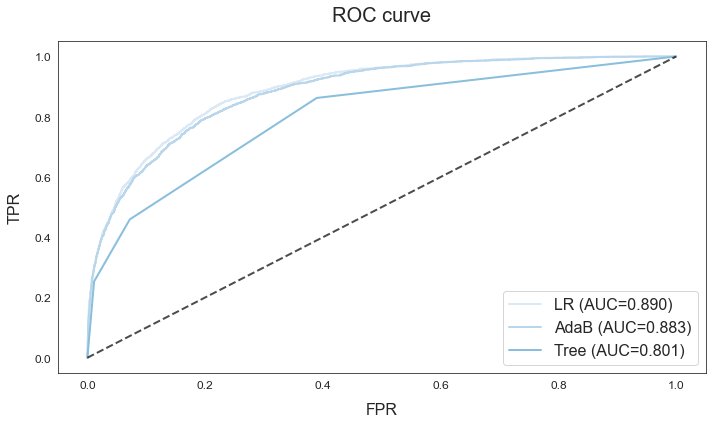

In [13]:
# Use the plotting attributes to further customize your plots!
atom_2.palette= 'Blues'
atom_2.style = 'white'

atom_2.plot_roc()

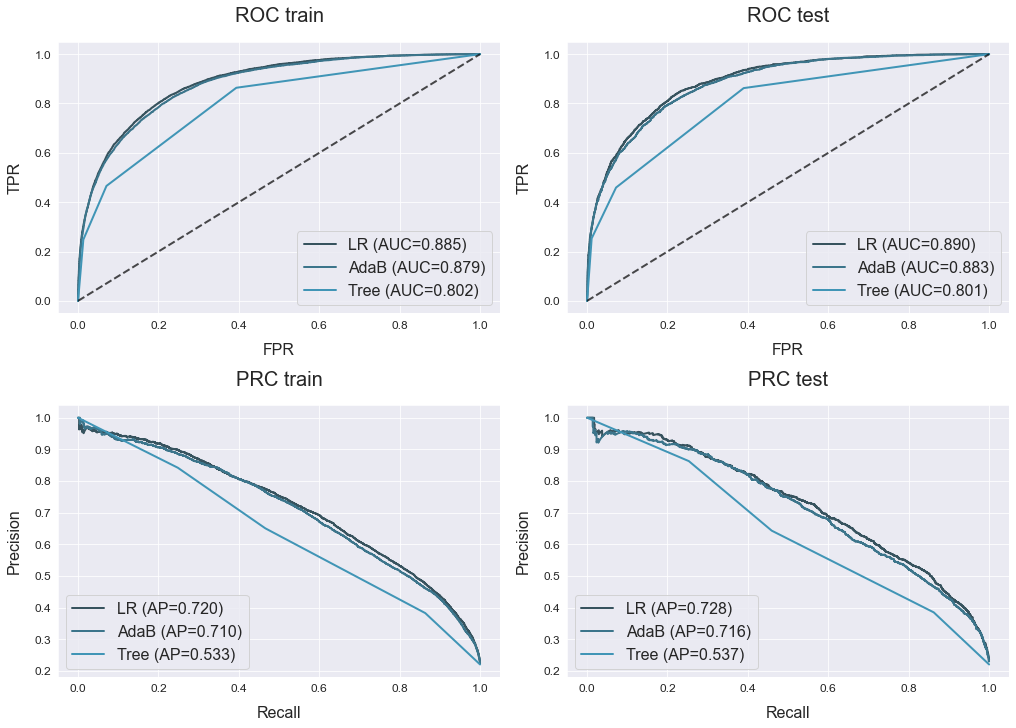

In [14]:
# Reset the aesthetics to their original values
atom_2.reset_aesthetics()

# Draw multiple plots in one figure using the canvas method
with atom.canvas(2, 2):
    atom_2.plot_roc(dataset="train", title="ROC train")
    atom_2.plot_roc(dataset="test", title="ROC test")
    atom_2.plot_prc(dataset="train", title="PRC train")
    atom_2.plot_prc(dataset="test", title="PRC test")